# Heart Disease Prediction: Analysis of Various ML Models

## Abstract

This report proposes a detailed analysis of various machine learning models in order to predict the presence (or absence) of heart disease. The main objective is to evaluate and compare the most popular models in order to identify the most suitable one for early detection of heart attacks.

Six different machine learning models were explored: Logistic Regression, Support Vector Machines (SVM), Linear Discriminant Analysis (LDA), Random Forest, Convolutional Neural Networks (CNN) and Neural Networks (NN). The database on which the models were trained is the [UCI Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease). Challenges we faced include the small size of the dataset, the imbalance of some classes (i.e., sex), and the absence of many values. Nevertheless, the features are related to very specific physical medical parameters, and therefore very useful for research, which is the reason why this dataset has been much studied.   

Before proceeding with model training, the dataset was analyzed and preprocessed.
In particular, an analysis was carried out to identify the best interpolation method for the missing values. Subsequently, parameter optimization by cross validation was carried out for each model. Performance evaluation metrics, in our case F1-score, AUC-ROC, accuracy, precision and the false negatives rate were used to compare the performance of the models. In particular we paid attention to the false negatives rate, since it is important to minimize the number of false negatives in order to avoid the risk of not detecting a heart attack, which is way worse than a false positive, since the former can lead to death, the latter to further tests.

From our research it follows that the best models are:
- Logistic Regression, with good overall metrics
- Support Vector Machines, for the lower rate of false negatives, i.e. 2 %

## Introduction

Early and accurate prediction of heart attacks is crucial for the prevention of cardiovascular disease, a leading cause of mortality. In this context, machine learning models may prove to be a promising resource for identifying risk factors and predicting the probability of heart attack occurrence.

The present study focuses on the comparative analysis of different machine learning models for heart attack prediction using the dataset provided by the Cleveland Clinic Foundation:[UCI Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease). The dataset contains about 920 records, each representing a patient with heart disease or without. The records include 14 clinical characteristics, which are very useful from a medical point of view. The study was conducted using a supervised machine learning approach. There are actually multiple levels of heart attack severity in the dataset: 0 for not present and then 1 to 4 for severity. We decided to work on a binary classification problem, i.e., to predict only the presence or absence of heart disease: 0 not present, 1 at risk of hearth attack. The dataset has been divided into training (64%), validation (16%) and testing (20%) for the LDA, SVM, Logistic Regression and Random Forest models. For the CNN and NN models, the dataset has been divided into training (70%), and testing and validation (30%). The training set was used to train the models, while the validation set was used to tune the hyperparameters. The test set was used to evaluate the performance of the models.

Through the detailed analysis of various machine learning models (Logistic Regression, Support Vector Machines (SVM), Linear Discriminant Analysis (LDA), Random Forest, Convolutional Neural Networks (CNN) and Neural Networks (NN)), we aim to develop a predictive system that can provide accurate and timely estimates regarding the occurrence of heart attacks. This could contribute greatly to medical practice by enabling targeted checkups and improving the management of cardiovascular conditions.

## Related work

A crucial part of our analysis involved researching the documentation of heart-related diseases. Our search was divided into three steps: search of scientific articles, with the aim to provide a biological and pathological background; search of related datasets, with the aim to serve as a benchmark for results and offer insights on how to analyze and filter our dataset and, lastly, search for already-existing related approaches on the pathology.

At the very beginning we searched for scientific articles to gain insights on the pathology at both macroscopic (the human body) and microscopic level (the cell). This effort was necessary to better understand the variables in our dataset and how to analise them. For instance, variables such as cholesterol and glucose play a crucial role at the microscopic level. On the other hand, variables related to pressure and chest pain are significant at the macroscopic level.

After performing these researches, we further investigated searching for documentation in already-existed or implemented approaches on the disease. The research was successful as we were able to find several related works that addresses the [*Deep Convolutional Neural Network for the Early Detection of Heart Disease*](https://www.mdpi.com/2227-9059/10/11/2796) and the [*comparison of Machine Learning Algorithms for the Prediction of Heart Disease*](https://www.ijraset.com/fileserve.php?FID=32591).

Finally, a useful resource was the [UCI Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease) page, which listed some models that were used as a benchmark for our results.

After this work, we proceeded with the analysis of our data.


## Division of the tasks

We divided the group work into the following phases: project identification, research on scientific articles related to our research topic, reasons for research interest, and potential developments. The criteria for choosing the theme were primarily based on the ability to apply the classification methods studied in the course without excessive concern about data cleaning or other related issues. However, data cleaning still played a significant role in the research. While the group actively and cohesively participated in selecting the topic, Marina Zanoni and Stefano Rinaldi took on the analysis and cleaning of the data.

The modeling, parameter tuning, and commentary on the metrics of the respective models were carried out by Filippo Parlanti and Giorgio Bertone. There were interactions among all group members where necessary, particularly during the final drafting and revision of the results.

## Dataset

### Libraries import

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from importlib import reload
from ydata_profiling import ProfileReport, compare
import optimize
reload(optimize)

# Ignore all warnings to avoid eccessive verbose
import warnings
warnings.filterwarnings(action='ignore')


# Set an initial seed to be used by all functions, for reproducibility
np.random.seed(42)

We used the package `ydata_profiling` to create an HTML page to inspect the dataset and do a brief Explanatory Data Analysis. We added the html file to the same folder of this notebook.

In [2]:
## Uncomment the following code to generate the profiling report
#
# dataset = pd.read_csv("heart_disease_uci.csv")
# report = ProfileReport(
#     dataset,
#     title="Trending Books",
#     dataset={
#         "description": "This profiling report was generated for the datacamp learning resources.",
#         "author": "Satyam Tripathi",
#         "copyright_holder": "DataCamp, Inc.",
#         "copyright_year": 2023,
#         "url": "<https://www.datacamp.com/>",
#     },
# )
# report.to_notebook_iframe()
# report = ProfileReport(dataset=dataset, title="Heart disease data")
# report.to_file("profile_report.html")

We took the dataset from here: [UCI Heart Disease dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

In the original dataset there where 76 attributes that had aready been reduced to 14 main features and the feature indicating the presence of the heart disease.

Below we print some dataset information, to have a clear view of it.

In [3]:
dataset = pd.read_csv('heart_disease_uci.csv')

dataset.drop('id', axis=1, inplace=True)
dataset

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB


The columns in the dataset represent the following attributes or measured quantities:

- `age` is the age of the person
- `sex` is the sex of the person: _Male / Female_
- `dataset` is a reference to the original dataset, because is a merge of four different datasets made in different countries: _Cleveland / Hungary / Switzerland / VA Long_ Beach
- `cp` stands for chest pain, and that can assume the values: _asymptomatic / atypical angina / non-anginal / typical angina_
- `trestbps` is the resting blood pressure on admission to the hospital (measured in _mmHg_)
- `chol` is the serum cholestoral (measured in _mg / dl_)
- `fbs` stands for fasting blood sugar. It's a boolean value which is true if the measured value is $> 120$ _mg/dl_
- `restecg` is the result of the resting electrocardiographic test: _lv hypertrophy / normal / st-t abnormality_
- `thalch` is the maximum heart rate achieved
- `exang` exercise induced angina: _True / False_
- `oldpeak` is the ST depression induced by exercise relative to rest
- `slope` is the slope of the peak exercise ST segment : _downsloping / flat / upsloping_
- `ca` is the number of major vessels (0-3) colored by flourosopy
- `thal` stands for thalassemia: _fixed defect / normal / reversable defect_
- `num` is the diasgnosis of heart disease: $0$ is negative while $1,2,3,4$ in increasing order identify the severity of the hearth disease    

### Preprocessing the dataset

#### **Categorical variables**

In this section we analize and transform categorical variables. Indeed the treatment of categorical variables holds a significant role in uncovering patterns, drawing insights, and making informed decisions. Categorical variables, which represent qualitative characteristics, often come in the form of labels or groups rather than numerical values. One essential technique in handling these variables is factorization, a process that transforms categorical labels into a numerical format, facilitating their incorporation into mathematical models.


In certain analytical contexts, the decision to encode categorical variables as 0, 1, 2 (and potentially 3) is driven by the need to convey the severity or magnitude of a phenomenon. This encoding scheme is particularly relevant when dealing with variables that exhibit an inherent ordinal nature, where the order among categories implies a certain level of intensity or significance.

In [5]:
# fbs
# 0 = FALSE , 1 = TRUE
dataset['fbs'] = dataset['fbs'].map({False: 0, True: 1})

dataset['fbs'] = pd.to_numeric(dataset['fbs'], errors='coerce')

As can be seen from the pie chart, the `sex` of the patients makes the dataset very unbalanced. We will remedy this problem by using functions that penalize the most represented classes, in this case the males.   

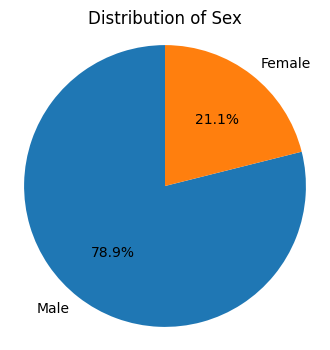

In [6]:
# Pie chart of sex
sex_values = dataset['sex'].value_counts(dropna=False)

plt.figure(figsize=(4,4))
sex_values.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sex')
plt.ylabel('')
plt.axis('equal');

In [7]:
# sex
# Conversion to 0 and 1
# 0 = MALE , 1 = FEMALE
dataset['sex'] = dataset['sex'].map({"Male": 0, "Female": 1})

In [8]:
# exang
# Conversion to 0 and 1
# 0 = FALSE , 1 = TRUE
dataset['exang'] = dataset['exang'].map({False: 0, True: 1})
dataset['exang'] = pd.to_numeric(dataset['exang'], errors='coerce')

Also the `restecg`

The `restecg` column is also very unbalanced, as the number of people with a normal value is much greater than people with abnormalities. In addition, a small slice of missing data can be observed. This will be remedied by interpolating the data, while we will deal with the problem of imbalance later.

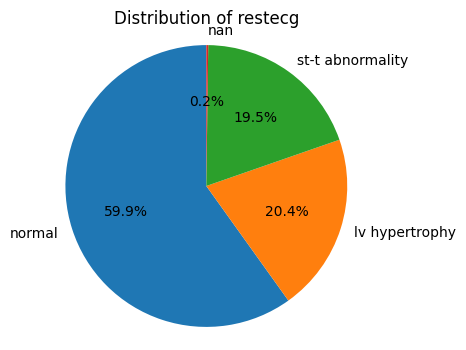

In [9]:
# Pie chart of restecg
restecg_values = dataset['restecg'].value_counts(dropna=False)

plt.figure(figsize=(4,4))
restecg_values.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of restecg')
plt.ylabel('')
plt.axis('equal');

In [10]:
# restecg
# Conversion to 0, 1 and 2 in order of increasing severity
dataset['restecg'] = dataset['restecg'].map({"normal": 0, "st-t abnormality": 1, "lv hypertrophy":2})

For the `slope` column we have some problem. In fact, as it can be observed from the pie chart below, the 33.6% of the values are missing. So we have to interpolate the value.

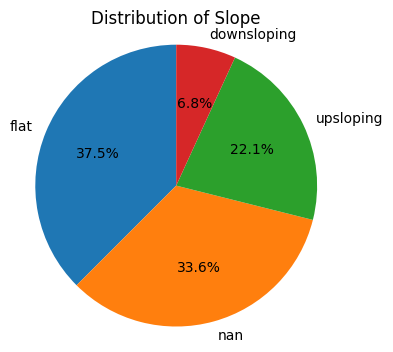

In [11]:
# Pie chart of slope
slope_values = dataset['slope'].value_counts(dropna=False)

plt.figure(figsize=(4,4))
slope_values.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Slope')
plt.ylabel('')
plt.axis('equal');

In [12]:
# slope
# Conversion to 0, 1 and 2 otherwise we cannot interpolate NaN values
dataset['slope'] = dataset['slope'].map({"upsloping": 0, "flat": 1, "downsloping":2})

In [13]:
# cp
# This is an example of ordinal data, where the order of the values is important
# That's why we decided to not use one-hot encoding here
dataset['cp'] = dataset['cp'].map({"asymptomatic": 0, "non-anginal": 1, "typical angina":2, "atypical angina": 3})

In [14]:
# num
# This column is the target value for the classification problem
# Since we only want to predict if a person has a heart attack or not, we can merge the values 2, 3 and 4 (the severity) into 1
# 0 = No heart attack , 1 = Heart attack
dataset['num'] = dataset['num'].map({0: 0, 1: 1, 2:1, 3:1, 4:1})

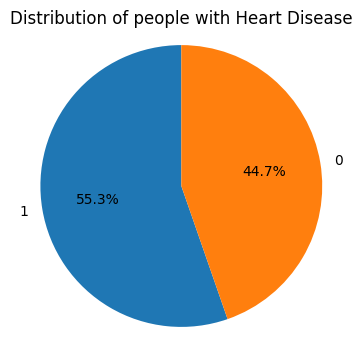

In [15]:
num_counts = dataset['num'].value_counts()

plt.figure(figsize=(4, 4))
num_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of people with Heart Disease')
plt.ylabel('')
plt.axis('equal');

The `num` column is balanced, meaning that there are almost half of people with heart disease and half of the people that are healty.

In [16]:
nan_percentage = round((dataset.isna().sum() / len(dataset)) * 100,2)
nan_percentage

age          0.00
sex          0.00
dataset      0.00
cp           0.00
trestbps     6.41
chol         3.26
fbs          9.78
restecg      0.22
thalch       5.98
exang        5.98
oldpeak      6.74
slope       33.59
ca          66.41
thal        52.83
num          0.00
dtype: float64

Having analyzed our problem, we no longer consider the following as relevant the features: `thal`, `ca` and `dataset`. In particular we will not focus only on the Cleveland Dataset, as most of the papers about this dataset do, but we will consider together all the four small dataset. This way we are also able to have a bigger training set for training purposes and testing of the various models we will introduce later. Moreover the columns `ca` and `thal` have, respectively, 66.4% and 52.8% of missing values. That is why we decided to eliminate them. In fact, we are interested in values that can be more easily measured by medical analysis, making diagnosis less complex and less expensive.

In [17]:
dataset = dataset.drop("thal", axis = 1)
dataset = dataset.drop("ca", axis = 1)
dataset = dataset.drop("dataset", axis = 1)

In [18]:
# How the dataset looks like now
dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,num
0,63,0,2,145.0,233.0,1.0,2.0,150.0,0.0,2.3,2.0,0
1,67,0,0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,1.0,1
2,67,0,0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,1.0,1
3,37,0,1,130.0,250.0,0.0,0.0,187.0,0.0,3.5,2.0,0
4,41,1,3,130.0,204.0,0.0,2.0,172.0,0.0,1.4,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,1,0,127.0,333.0,1.0,1.0,154.0,0.0,0.0,NaN,1
916,62,0,2,NaN,139.0,0.0,1.0,NaN,NaN,NaN,NaN,0
917,55,0,0,122.0,223.0,1.0,1.0,100.0,0.0,0.0,NaN,1
918,58,0,0,NaN,385.0,1.0,2.0,NaN,NaN,NaN,NaN,0


### Fixing the missing values

Missing values will in the next step be a focal point. We delve in the nature of methods could best apply to the task of filling the gaps and test the methods on all variables.

In particular the tecniqued used were interpolation by the **nearest** values or linear interpolation.


In [19]:
missing_val =dataset.isna().sum().to_dict()
df = pd.DataFrame(list(missing_val.items()), columns=['Variables', 'Missing Values'])

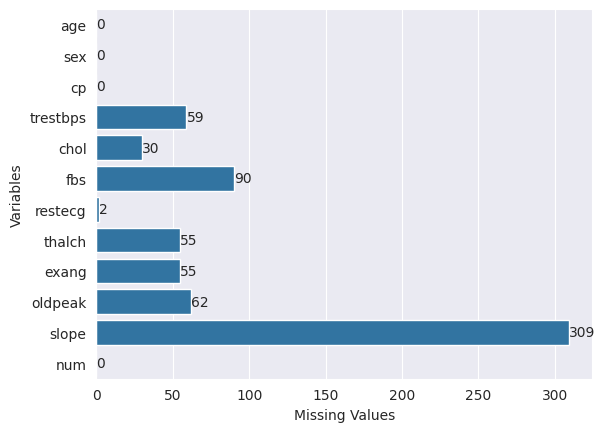

In [20]:
# set the style
sns.set_style("darkgrid")

#Plot a barplot
ax = sns.barplot(
    data=df,
    x='Missing Values',
    y='Variables',
    capsize=.4,
    estimator="sum"
    # color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
)

ax.bar_label(ax.containers[0], fontsize=10);
plt.show()


Below you can see a little summary of the various features in the dataset.

In [21]:
dataset.describe().round(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,num
count,920.00,920.00,920.00,861.00,890.00,830.00,918.00,865.00,865.00,858.00,611.00,920.00
mean,53.51,0.21,0.89,132.13,199.13,0.17,0.60,137.55,0.39,0.88,0.77,0.55
std,9.42,0.41,1.16,19.07,110.78,0.37,0.81,25.93,0.49,1.09,0.62,0.50
min,28.00,0.00,0.00,0.00,0.00,0.00,0.00,60.00,0.00,-2.60,0.00,0.00
25%,47.00,0.00,0.00,120.00,175.00,0.00,0.00,120.00,0.00,0.00,0.00,0.00
50%,54.00,0.00,0.00,130.00,223.00,0.00,0.00,140.00,0.00,0.50,1.00,1.00
75%,60.00,0.00,1.00,140.00,268.00,0.00,1.00,157.00,1.00,1.50,1.00,1.00
max,77.00,1.00,3.00,200.00,603.00,1.00,2.00,202.00,1.00,6.20,2.00,1.00


## Cross-validation for missing values

The results of cross-validation using both linear and K-nearest neighbors (KNN) imputation methods are presented, with consideration given to the fact that the linear method demonstrates lower performance and relies on assumptions that are less suitable for our dataset. Particularly, these assumptions may be less valid for qualitative variables, especially those of ordinal nature. In contrast, KNN, as a non-parametric and flexible imputation approach, is shown to be more adept at capturing complex relationships and accommodating various types of variables without necessitating stringent assumptions.


Cross-validation is carried out by applying logistic regression, providing a rough evaluation of metrics essential for comparison. The more refined results, incorporating additional strategies, will be introduced at a later stage.

### Interpolation using KNN

The KNNImputer class provides imputation for filling in missing values using the k-Nearest Neighbors approach. By default, a euclidean distance metric that supports missing values, nan_euclidean_distances, is used to find the nearest neighbors. Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed. When the number of available neighbors is less than n_neighbors and there are no defined distances to the training set, the training set average for that feature is used during imputation. If there is at least one neighbor with a defined distance, the weighted or unweighted average of the remaining neighbors will be used during imputation. If a feature is always missing in training, it is removed during transform. For more information on the methodology, see ref. [OL2001].

https://scikit-learn.org/stable/modules/impute.html#knnimpute

In [22]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")

knn_res= imputer.fit_transform(dataset)

In [23]:
knn_df = pd.DataFrame(knn_res,columns=dataset.columns)
knn_df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
num         0
dtype: int64

In [105]:
knn_df_orig = knn_df.copy()
knn_df["kfold"] = -1
knn_df = knn_df.sample(frac=1).reset_index(drop=True)
y = knn_df["num"].values

kf = StratifiedKFold(n_splits=50)

for fold, (train_idx, val_idx) in enumerate(kf.split(X=dataset, y=y)):
    knn_df.loc[val_idx, "kfold"] = fold


In [106]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

auc_stored = []

def run(fold: int) -> None:
    # Select features excluding "id", "num", and "kfold"
    features = [f for f in knn_df.columns if f not in ("id", "num", "kfold")]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(knn_df)

    # Split the dataset into training and validation sets based on the fold
    df_train = knn_df[knn_df["kfold"] != fold].reset_index(drop=True)
    df_valid = knn_df[knn_df["kfold"] == fold].reset_index(drop=True)


    # Create a pipeline with logistic regression
    model = Pipeline(steps=[('classifier', LogisticRegression(max_iter=1000))])

    # Train the model
    model.fit(df_train[features], df_train.num.values)

    # Predict probabilities for the validation set
    valid_preds = model.predict_proba(df_valid[features])[:, 1]

    # Calculate AUC (Area Under the ROC Curve) for model evaluation
    auc = metrics.roc_auc_score(df_valid.num.values, valid_preds)
    auc_stored.append(auc)

    # Print the fold number and AUC score
    # print(f"FOLD: {fold} | AUC = {auc:.3f}")

# Run the function for each fold
for i in range(50):
    run(i)

knn_df.drop("kfold", axis=1, inplace=True)


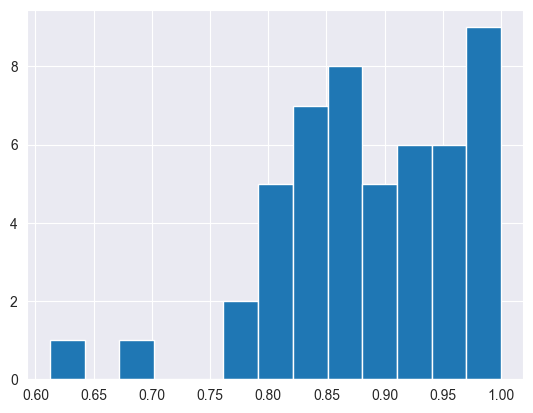

In [107]:
plt.hist(auc_stored,bins=13);

In [108]:
array_auc=np.array(auc_stored);
q25, q50, q75 = np.percentile(array_auc, [25, 50, 75]);
print('min',np.min(array_auc),'max',np.max(array_auc),'\n',
      'quantiles', round(q25,3),round(q50,3),round(q75, 3))

min 0.6125 max 1.0 
 quantiles 0.834 0.887 0.962


Values are dense around the range 0.80-0.95 so this let us think that indeed for some subsets the performance are not brilliant but as they're not a evident unbalancedness of the performances we may think that the imputed data aligns with reality

### Linear interpolation

In [109]:
dataset1=dataset.copy()

In [110]:
# Retrive the index list
index_list = dataset1.index.tolist()

# List of the columns to be interpolated
not_nan_columns = ['slope', 'trestbps', 'fbs', 'chol', 'restecg', 'thalch', 'exang', 'oldpeak']

for column in not_nan_columns:
  not_nan = dataset1[column].notna()
  interpolated_values = interp1d(np.array(index_list)[not_nan], dataset1[column][not_nan], kind='linear', fill_value='extrapolate')
  dataset1[column] = np.where(not_nan, dataset1[column], interpolated_values(index_list))


Now we can focus on missing values. In particular, we have decided to interpolate the missing data by the following methodology:
- `kind ='linear'`: specifies the interpolation method to be used. In this case is a linear interpolation. Notice that this technique is particularly effective when there is an approximately linear relationship between the known data points.
- `fill_value = 'extrapolate'`: specifies how to handle values outside the input data range. With this choice, the interpolation function will consider also data point outside of the range of input data.
- `round`: we round when necessary to have values which are compatible with the support as we're working with random variables

In [111]:
dataset1.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
num         0
dtype: int64

Now that we have removed all the NaN values we can normalize the dataset, so that we can optimize all the parameter optimization methods and speed up model training. Obviously we are not going to normalize the categorical values that assume boolean values 0 and 1. We will also not normalize categorical variables where the associated integer value indicates greater symptom severity.

In [112]:
dataset1["kfold"] = -1
dataset1 = dataset1.sample(frac=1).reset_index(drop=True)
y = dataset1["num"].values

df = StratifiedKFold(n_splits=50)

for fold, (train_idx, val_idx) in enumerate(df.split(X=dataset1, y=y)):
    dataset1.loc[val_idx, "kfold"] = fold


In [113]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

auc_stored = []

def run(fold: int) -> None:
    # Select features excluding "id", "num", and "kfold"
    features = [f for f in dataset1.columns if f not in ("id", "num", "kfold")]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(knn_df)

    # Split the dataset1 into training and validation sets based on the fold
    df_train = dataset1[dataset1["kfold"] != fold].reset_index(drop=True)
    df_valid = dataset1[dataset1["kfold"] == fold].reset_index(drop=True)


    # Create a pipeline with logistic regression
    model = Pipeline(steps=[('classifier', LogisticRegression(max_iter=1000))])

    # Train the model
    model.fit(df_train[features], df_train.num.values)

    # Predict probabilities for the validation set
    valid_preds = model.predict_proba(df_valid[features])[:, 1]

    # Calculate AUC (Area Under the ROC Curve) for model evaluation
    auc = metrics.roc_auc_score(df_valid.num.values, valid_preds)
    auc_stored.append(auc)

    # Print the fold number and AUC score
    # print(f"FOLD: {fold} | AUC = {auc:.3f}")

# Run the function for each fold
for i in range(50):
    run(i)

dataset1.drop('kfold', axis=1, inplace=True)

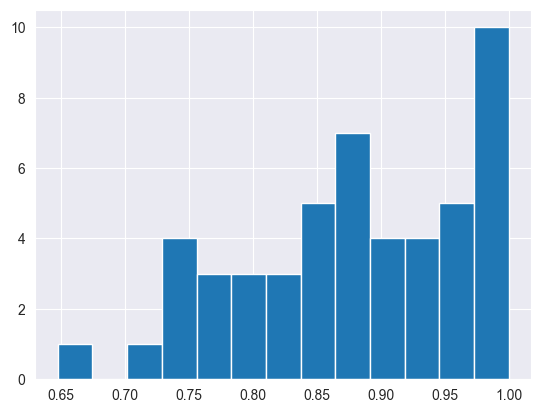

In [114]:
plt.hist(auc_stored,bins=13);

In [ ]:
numerical_columns = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'slope']
scaler = MinMaxScaler()
dataset1[numerical_columns] = scaler.fit_transform(dataset1[numerical_columns])

In [ ]:
from sklearn.preprocessing import LabelEncoder


cat_vars = ['cp', 'restecg']

label_encoder = LabelEncoder()
for col in cat_vars:
    dataset1[col] = label_encoder.fit_transform(dataset1[col])
dataset1[cat_vars] = scaler.fit_transform(dataset1[cat_vars])

In [ ]:
# How the dataset looks like with the linear interpolation
dataset1

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,num
0,0.612245,0,0.000000,0.64,0.429519,0.0,1.0,0.492958,1.0,0.636364,0.500000,1
1,0.530612,0,1.000000,0.80,0.505804,0.0,0.0,0.809859,0.0,0.295455,0.000000,0
2,0.367347,0,0.000000,0.55,0.391376,0.0,0.0,0.457746,1.0,0.522727,0.500000,1
3,0.734694,0,0.666667,0.85,0.376451,0.0,1.0,0.669014,0.0,0.363636,0.500000,0
4,0.448980,0,1.000000,0.85,0.346600,0.0,0.5,0.394366,0.0,0.295455,0.312500,0
...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.571429,0,1.000000,0.65,0.366501,0.0,1.0,0.725352,0.0,0.295455,0.000000,0
916,0.346939,1,0.000000,0.66,0.492537,0.0,0.0,0.591549,0.0,0.295455,0.500000,0
917,0.612245,0,0.000000,0.58,0.000000,0.0,0.0,0.450704,0.0,0.409091,0.000000,1
918,0.734694,0,0.000000,0.75,0.320066,0.0,0.5,0.528169,1.0,0.352273,0.500000,1


After testing the behavior of the dataset under the various types of interpolation, we can decide which one to use. Since interpolation by KNN turns out to have better AUC-ROC metrics than the others, we will use that dataset.

In [31]:
dataset = knn_df_orig.copy()  

### Train/Test/Val split

Now we will split the dataset in:
- the matrix of features $X$
- the matrix of the labels $y$

In [32]:
numerical_columns = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'slope']
scaler = MinMaxScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,num
0,0.714286,0.0,2.0,0.725,0.386401,1.0,2.0,0.633803,0.0,0.556818,1.0,0.0
1,0.795918,0.0,0.0,0.800,0.474295,0.0,2.0,0.338028,1.0,0.465909,0.5,1.0
2,0.795918,0.0,0.0,0.600,0.379768,0.0,2.0,0.485915,1.0,0.590909,0.5,1.0
3,0.183673,0.0,1.0,0.650,0.414594,0.0,0.0,0.894366,0.0,0.693182,1.0,0.0
4,0.265306,1.0,3.0,0.650,0.338308,0.0,2.0,0.788732,0.0,0.454545,0.0,0.0


In [33]:
X = dataset.drop('num', axis=1)
y = dataset['num']

print(f"The shape of X is: {X.shape}")
print(f"The shape of y is: {y.shape}")

The shape of X is: (920, 11)
The shape of y is: (920,)


In order to have a clear view of the interdependence among the feature we plot here the correlation matrix.

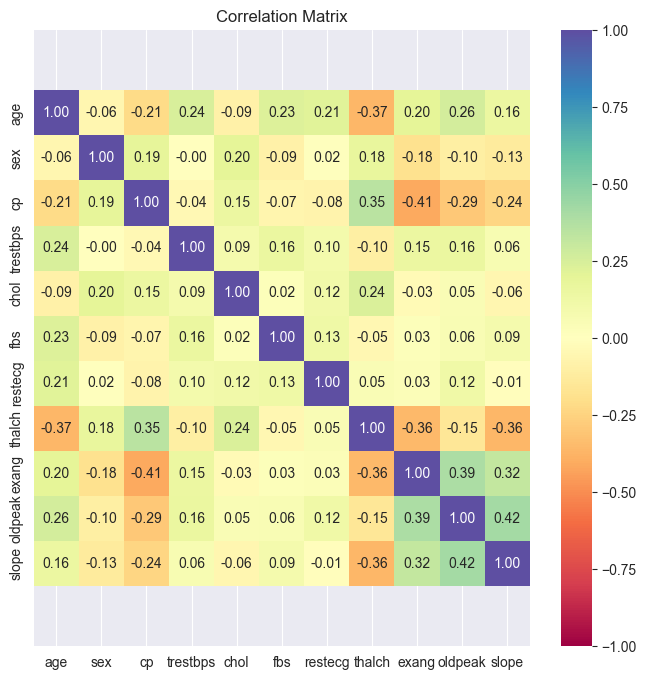

In [ ]:
# Correlation matrix of the features

plt.figure(figsize=(8,8))
sns.heatmap(X.corr(), annot=True, cmap='Spectral', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.axis('equal');

As can be seen from the correlation matrix, there is no explicit linear dependence between the various features. This is good since we otherwise may run into overfitting or underfitting more easily. In such cases the model will fails to capture the true relationship with the real target label because of collinear predictors.

We have decided to divide the dataset into training and testing in the following percentages:
- training: $80\ \%$
- testing: $20\ \%$

Since we will use the `grid search cross validation`` strategy, the training sample will in turn be divided into $80\ \%$ training and $20 %$ validation, for 5 folds.
In the end we will have:
- training: $64\ \%$
- validation: $16\ \%$
- testing: $20\ \%$


In [34]:
# Splitting the dataset into training and test sets
# 80% training, 20% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"The shape of X_train is: {X_train.shape}")
print(f"The shape of X_test is : {X_test.shape}")


The shape of X_train is: (736, 11)
The shape of X_test is : (184, 11)


# Experimental results

## Logistic Regression

First of all we train a Logistic Regression model with various choices for the parameter. In particular we consider:
- the regularization function that can be _L2 / elasticnet_. For elasticnet we will specify different ratio for the L1 and L2 distances
- the regularization parameter (we will use parameters of different scales)

We will use the K-Fold cross validation grid search procedure in wich we consideer $K=5$. In doing this we are considering $80\%$ of the dataset as training set for the cross validation procedure, while the remaining $20\%$ will be used for testing purpose.

/home/filippo/anaconda3/envs/fds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/filippo/anaconda3/envs/fds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/filippo/anaconda3/envs/fds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/filippo/anaconda3/envs/fds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/filippo/anaconda3/envs/fds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when pena

/home/filippo/anaconda3/envs/fds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/filippo/anaconda3/envs/fds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/filippo/anaconda3/envs/fds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/filippo/anaconda3/envs/fds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/filippo/anaconda3/envs/fds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when pena

Best Parameters: {'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l2'}
F1 Score  : 0.786
AUC Score : 0.86341
Accuracy  : 0.78804
Precision : 0.78976
FN Rate   : 7 %


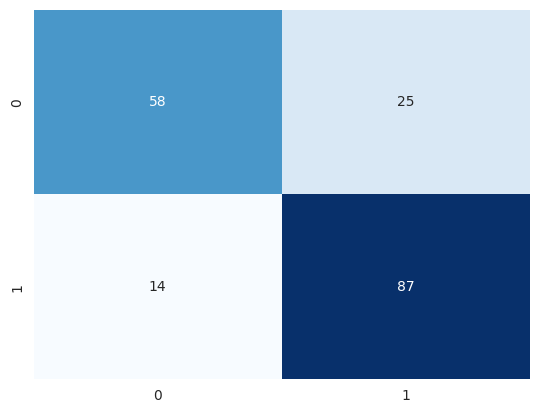

In [50]:
# Create the model with class weights balanced to deal with the imbalanced dataset
model = LogisticRegression(class_weight = "balanced", verbose = 0)

# Setting up the hyperparameter grid for GridSearchCV
param_grid = {
    'penalty' : ['l2', 'elasticnet'],
    'l1_ratio' : np.linspace(0,1,11),
    'C': [0.001, 0.01, 0.1, 1, 10, 100]# Regularization parameter
}

model_LR = optimize.run(model, param_grid, X_train, y_train, X_test, y_test)

We can see that the best models are for the L2 regularization. We now try to fix it and to search for a better regularization parameter in range $[0,1]$ instead.

Best Parameters: {'C': 0.0298}
F1 Score  : 0.81442
AUC Score : 0.88011
Accuracy  : 0.81522
Precision : 0.81538
FN Rate   : 7 %


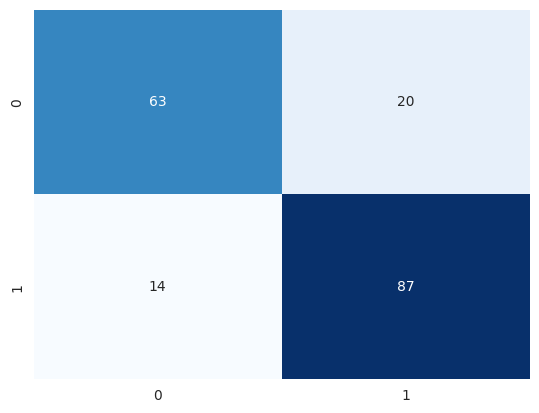

In [51]:
# Create the model with class weights balanced to deal with the imbalanced dataset
model = LogisticRegression(class_weight="balanced", penalty = 'l2')

# Setting up the hyperparameter grid for GridSearchCV
param_grid = {
    'C': np.linspace(0.01, 1, 101)  # Regularization parameter
}

model_LR_param = optimize.run(model, param_grid, X_train, y_train, X_test, y_test)

Since we do not obtain significantly better results, we consider the best logistic regression model to be the one previously trained.

Best Parameters: {'C': 1}
F1 Score  : 0.77995
AUC Score : 0.89789
Accuracy  : 0.78804
Precision : 0.81015
FN Rate   : 3 %


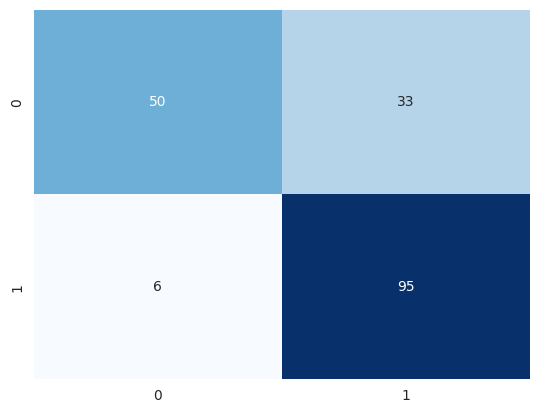

In [52]:
# Create the model with class weights balanced to deal with the imbalanced dataset
model = LogisticRegression(class_weight = {0:1, 1:2})

# Setting up the hyperparameter grid for GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
}

model_LR_weight = optimize.run(model, param_grid, X_train, y_train, X_test, y_test)

By trying to change the weight of the classes in the model setup, we notice that we are able to rate of False Negatives from 7% to 3%. Unfortunately, we increase the False Positives too significantly. We can also observe that the accuracy and the F1 score decrease significantly. 

However, in our case, it is more important to minimize the number of False Negatives, since it is more important to avoid the risk of not detecting a heart attack, which is way worse than a false positive, since the former can lead to death, the latter to further tests, thus the choice of the best model is the one with the lowest rate of False Negatives, also considering that the other metrics don't decrease too much.

Thus, the performance of the best model is the following:
- `F1 Score  :` $0.7795$
- `AUC Score :` $0.8979$
- `Accuracy  :` $0.7881$
- `Precision :` $0.8102$
- `FN Rate   :` $3\ \%$


## LDA

In [68]:
# Defining the LDA
LDA = LinearDiscriminantAnalysis()

k = 5
kf = StratifiedKFold(n_splits = k, random_state = 42, shuffle=True)

# Dataframe to store metrics and parameters
df_metrics = pd.DataFrame(columns = ['f1', 'auc', 'accuracy','precision','conf_matrix', 'TP', 'TN', 'FP', 'FN'])

for i, (train_ids, test_ids) in enumerate(kf.split(X, y)):
    X_train = X.iloc[train_ids]
    X_test = X.iloc[test_ids]
    y_train = y.iloc[train_ids]
    y_test = y.iloc[test_ids]

    # Fitting the LDA LDA on the training data
    LDA.fit(X_train, y_train)

    # # Transforming the data in order to reduce the dimensionality
    # X_train = LDA.transform(X_train)
    # X_test = LDA.transform(X_test)

    # Fitting the Logistic Regression LDA on the training data
    LDA.fit(X_train, y_train)

    # Predicting probabilities
    y_pred_proba = LDA.predict_proba(X_test)[:, 1]

    # Calculating AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    # Calculating F1 score
    y_pred = LDA.predict(X_test)
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Saving metrics
    row = pd.Series()
    row['f1'] = round(f1, 5)
    row['auc'] = round(roc_auc, 5)
    row['accuracy'] = round(metrics.accuracy_score(y_test, y_pred), 5)
    row['precision'] = round(metrics.precision_score(y_test, y_pred, average='weighted'), 5)
    row['conf_matrix'] = conf_matrix
    row['TP'] = conf_matrix[1][1]
    row['TN'] = conf_matrix[0][0]
    row['FP'] = conf_matrix[0][1]
    row['FN'] = conf_matrix[1][0]
    df_metrics = pd.concat([df_metrics, pd.DataFrame(row).transpose()]).reset_index(drop=True)

F1 Score  : 0.80921
AUC Score : 0.88335
Accuracy  : 0.80978
Precision : 0.81016
FN Rate   : 8 %


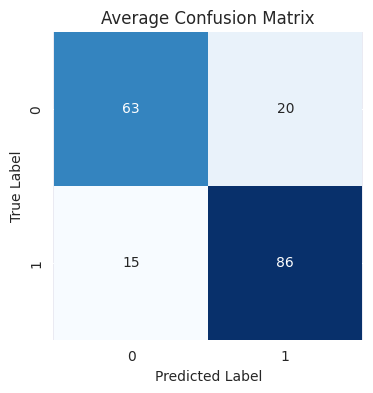

In [69]:
optimize.print_statistics(df_metrics)

The scores for this model are:
- `F1` : $0.80921$
- `AUC-ROC` : $0.88335$
- `Accuracy` : $0.80978$
- `Precision` : $0.81016$
- `FN rate` : $8\ \%$

## Random Forest

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
F1 Score  : 0.80939
AUC Score : 0.88678
Accuracy  : 0.80978
Precision : 0.80943
FN Rate   : 8 %


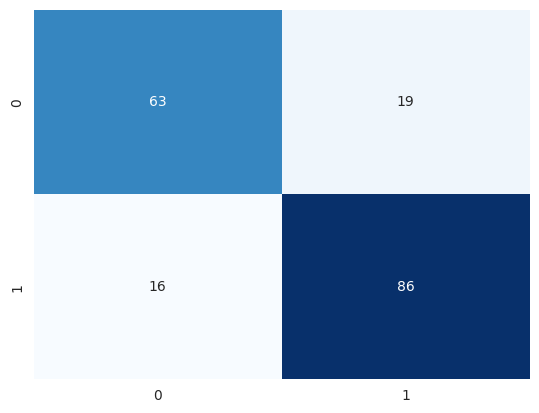

In [55]:
# Defining the Random Forest model
model = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight="balanced")

# Setting up hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 20, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

model_RF = optimize.run(model, param_grid, X_train, y_train, X_test, y_test)

The scores for this model, considering the refined research, are:
- `F1` : $0.80939$
- `AUC-ROC` : $0.88678$
- `Accuracy` : $0.80978$
- `Precision` : $0.80943$
- `FN rate` : $8\ \%$

These score are a similar to the ones obtained using Logistic Regression.

## SVM

Best Parameters: {'C': 0.01, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
F1 Score  : 0.78149
AUC Score : 0.85557
Accuracy  : 0.78804
Precision : 0.80209
FN Rate   : 4 %


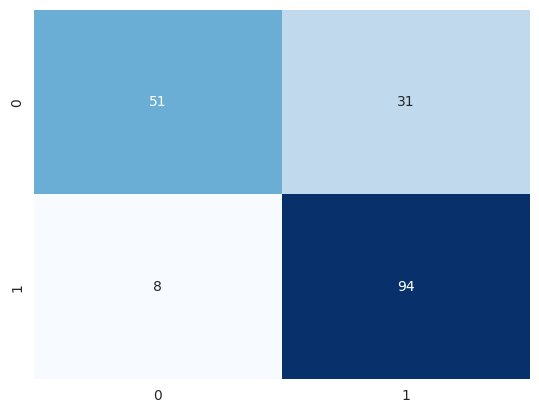

In [59]:
# Create the model with class weights balanced to deal with the imbalanced dataset
model = SVC(class_weight="balanced", probability=True, random_state=42)

# Setting up the hyperparameter grid for GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [1, 2, 3]
}

model_SVC = optimize.run(model, param_grid, X_train, y_train, X_test, y_test)

Now we try to optimize the regularization parameter C while weighting differently the classes.

Best Parameters: {'C': 0.1, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
F1 Score  : 0.77221
AUC Score : 0.87637
Accuracy  : 0.78261
Precision : 0.81016
FN Rate   : 2 %


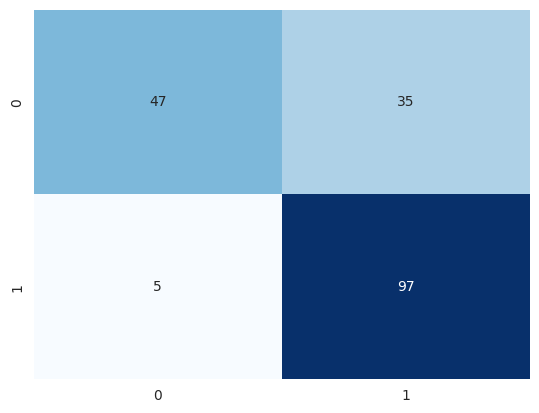

In [60]:
# Create the model with class weights balanced to deal with the imbalanced dataset
model = SVC(class_weight={0:1, 1:2}, probability=True, random_state=42)

# Setting up the hyperparameter grid for GridSearchCV
param_grid = {
    'C': np.linspace(0,1,101),  # Regularization parameter
    'kernel': ['linear'],
    'gamma': ['scale'],
    'degree': [1]
}

model_SVC_weight = optimize.run(model, param_grid, X_train, y_train, X_test, y_test)


In this case we see an improvement in the metric: 
- `F1` : $0.77221$
- `AUC-ROC` : $0.87637$
- `Accuracy` : $0.78261$
- `Precision` : $0.81016$
- `FN rate` : $2\ \%$ 

In particular the FN rate is particularly low, which is one of our main goal of this research. The FP positive rate is still high, but the other metrics are all good.  


## Convolutional Neural Network

Now we build the CNN. We will use the following architecture, proposed by [this paper](https://www.mdpi.com/2227-9059/10/11/2796):
- 2 Convolutional layers with 128 filters, with kernel size of 3
- 4 Dense layers with 128 neurons
- 4 Dense layers with 64 neurons
- 1 Output layer with 1 neuron

We will use the `elu` activation function and the `MaxPooling` with pool size of 2.
As loss function we will use the `binary crossentropy`, since we have a binary classification problem and since it is what was suggested by the paper. We will use the `Nadam` optimizer, as this is what the author used too.

As before we will use the K-Fold cross validation procedure in wich we consideer $K=5$. In doing this we are considering $70\%$ of the dataset as training set , while the remaining $30\%$ will be used for validation and testing purpose.

 To avoid overfitting we will use dropouts of ranodm units in the hidden layers of the network as well as the early stopping callback, which will stop the training if the validation loss does not improve for 20 epochs. We will also use the `ReduceLROnPlateau` callback, which will reduce the learning rate by a factor of 0.2 if the validation loss does not improve for 5 epochs. Moreover, we will use the `ModelCheckpoint` callback, which will save the best model found during the training based on validation loss and will restore it at the end of the training.

 In the optimizer function we decided to use class weights of 1 for class 0 (healthy) and 1.5 for class 1 (hearth disease). This is partly because the dataset is slightly unbalanced, but mainly because we want to minimize the false negatives and by increasing the weight of the first class we are penalizing the prediction of a sick person as healthy more than the prediction of a healthy person as sick, thus we are penalizing the false negatives more. In other words, by assigning different class weights in the optimizer function, we are adjusting the importance of each class during the training process. A higher weight for class 1 (heart disease) signals that misclassifying instances of this class is more costly than misclassifying instances of class 0 (healthy).

 Finally we are also choosing a probability threshold of $0.49$ for classification as sick. Doing so we hope to collect those instances in which the model was less sure of the prediction as healthy and to classify them as sick since the consequences of this misclassification are more serious than the opposite.

2023-12-27 16:22:56.073452: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


3/3 [==============================] - 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.68      0.76        28
         1.0       0.82      0.93      0.87        45

    accuracy                           0.84        73
   macro avg       0.84      0.81      0.82        73
weighted avg       0.84      0.84      0.83        73



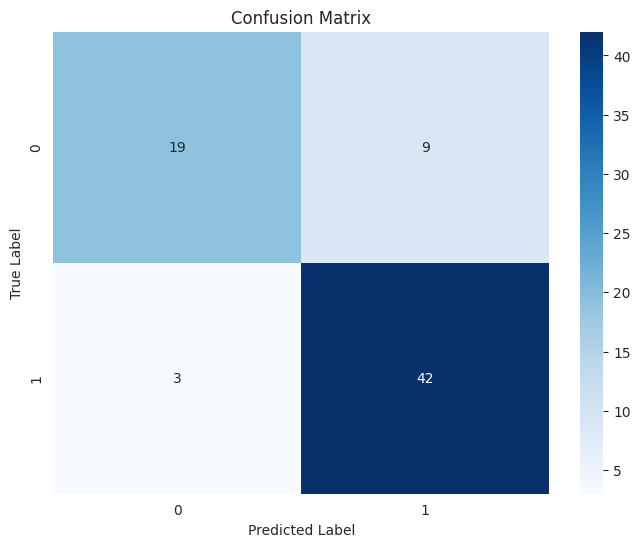

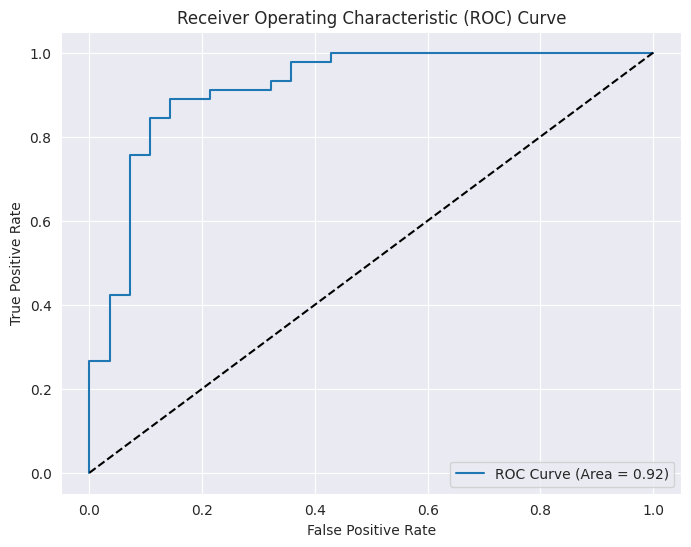

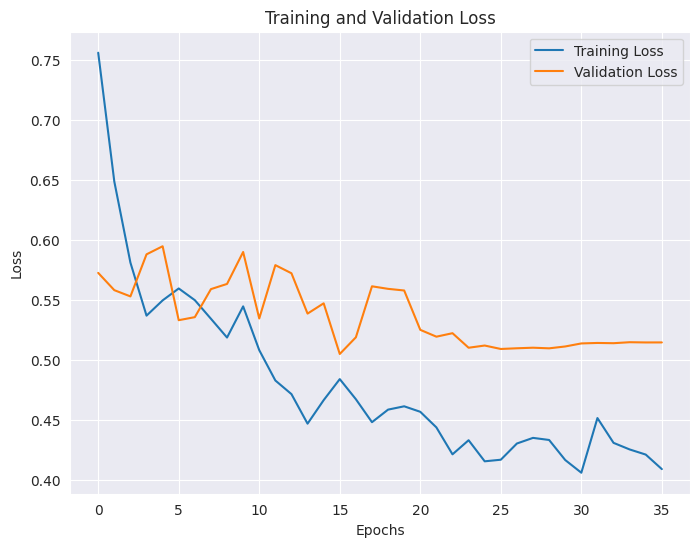

3/3 [==============================] - 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.53      0.64        32
         1.0       0.71      0.90      0.80        41

    accuracy                           0.74        73
   macro avg       0.76      0.72      0.72        73
weighted avg       0.75      0.74      0.73        73



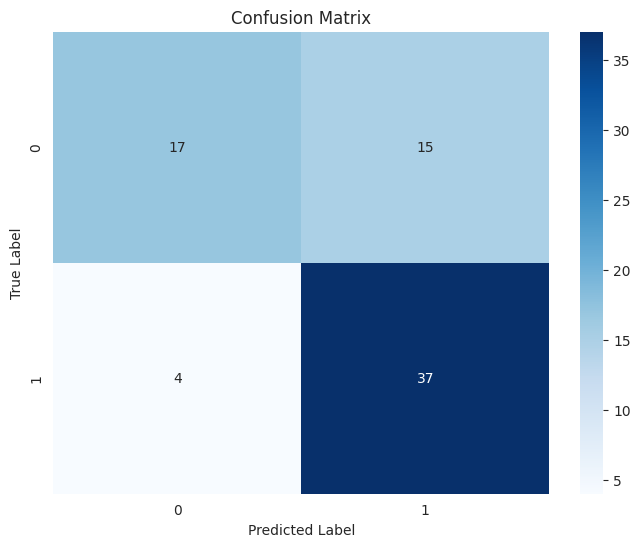

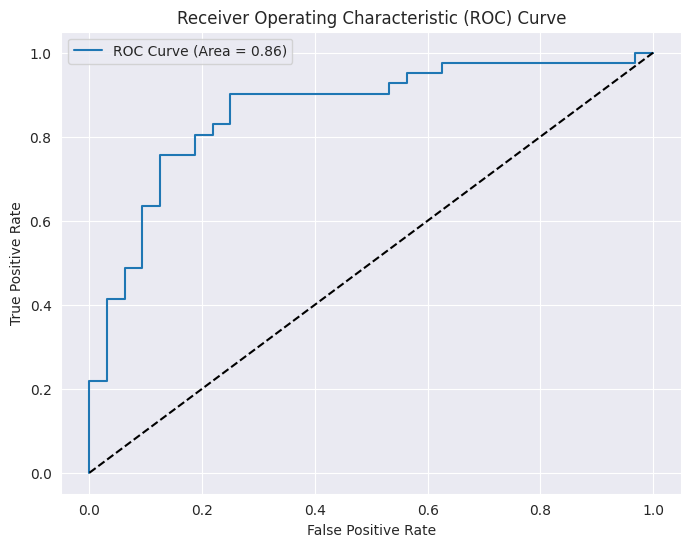

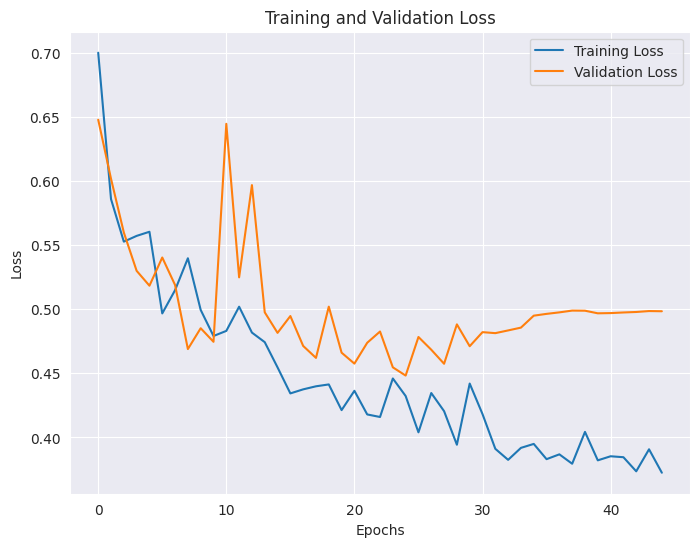

3/3 [==============================] - 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.60      0.69        30
         1.0       0.76      0.91      0.83        43

    accuracy                           0.78        73
   macro avg       0.79      0.75      0.76        73
weighted avg       0.79      0.78      0.77        73



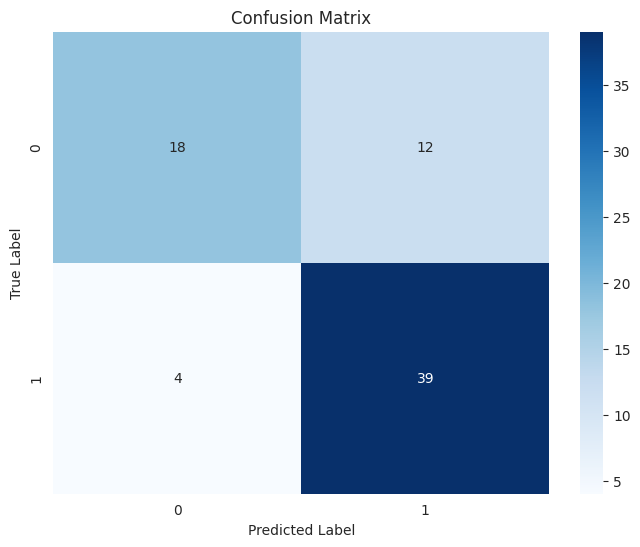

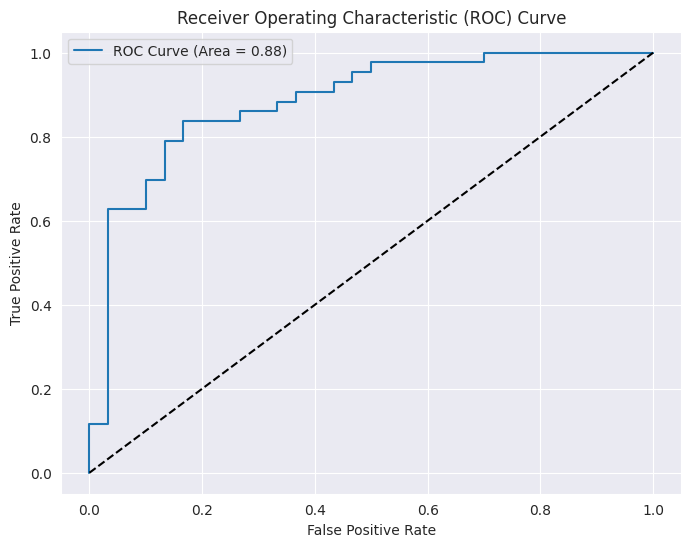

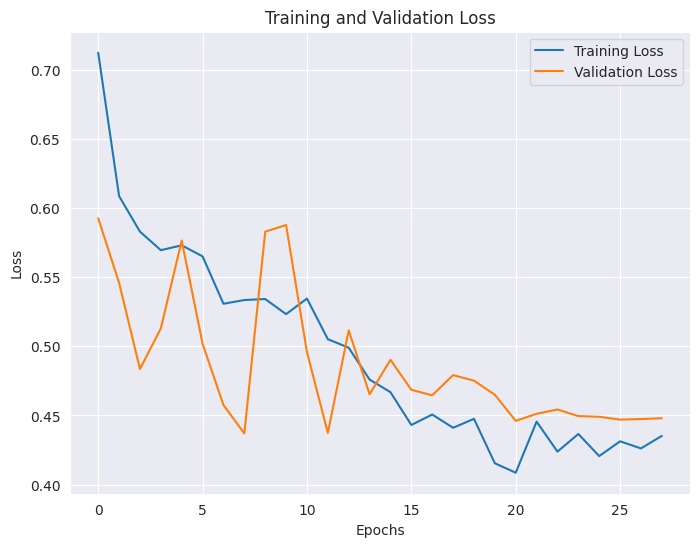

3/3 [==============================] - 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78        27
         1.0       0.87      0.87      0.87        46

    accuracy                           0.84        73
   macro avg       0.82      0.82      0.82        73
weighted avg       0.84      0.84      0.84        73



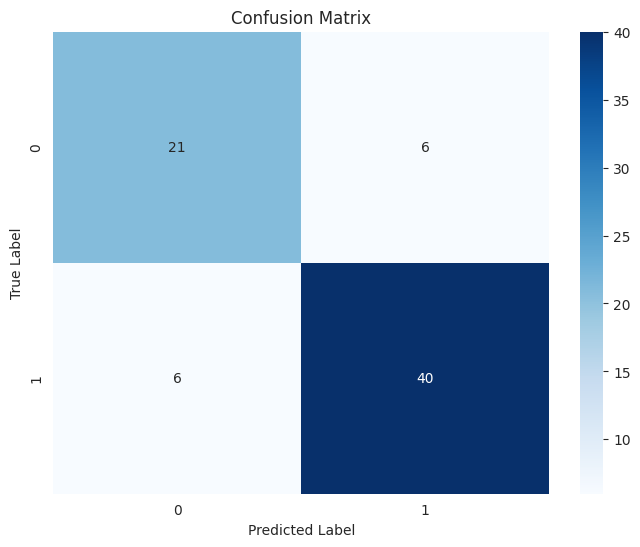

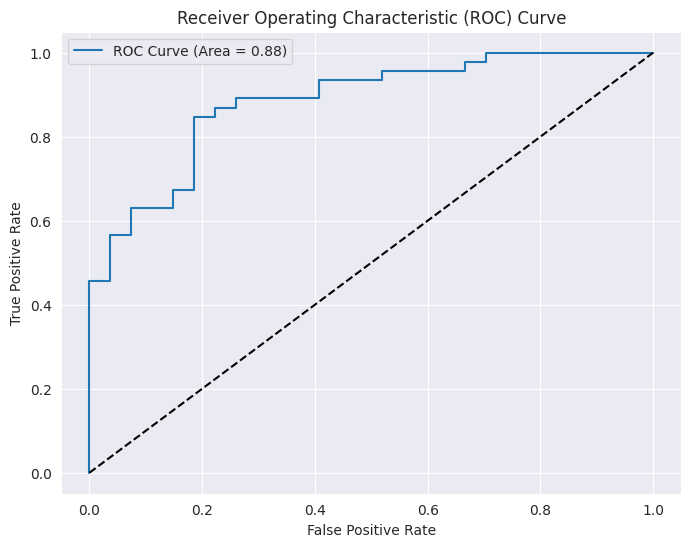

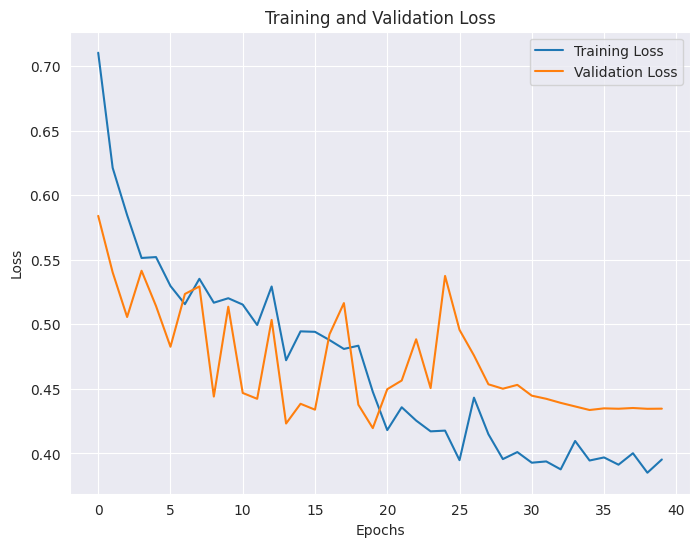

3/3 [==============================] - 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.58      0.68        33
         1.0       0.72      0.90      0.80        40

    accuracy                           0.75        73
   macro avg       0.77      0.74      0.74        73
weighted avg       0.77      0.75      0.75        73



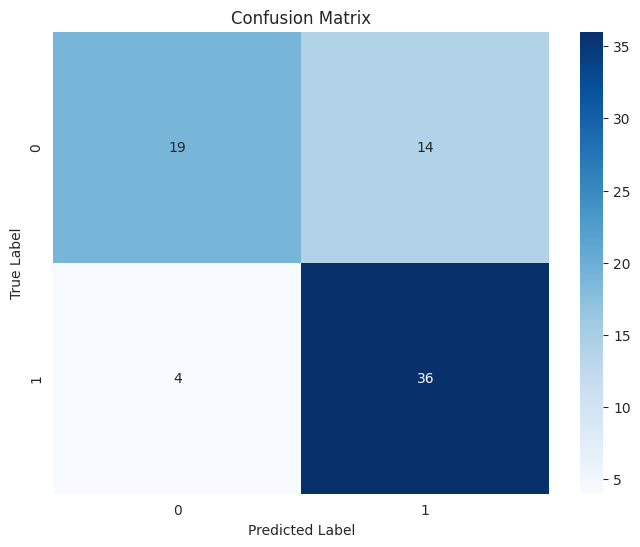

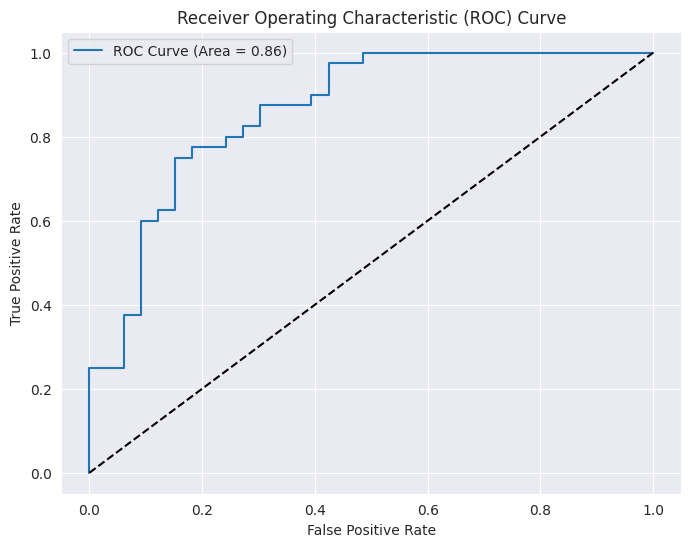

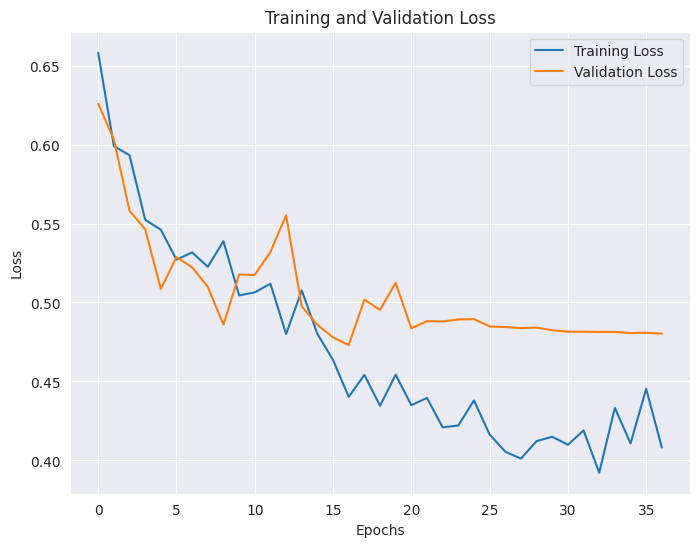

------------------------------------------------------------------------------------------------ 
 ------------------------------------------------------------------------------------------------ 
 ------------------------------------------------------------------------------------------------ 
 ------------------------------------------------------------------------------------------------ 

Mean AUC: 0.88 (+/- 0.02)
Mean F1 Score: 0.78 (+/- 0.04)
Mean FN Rate: 0.06 (+/- 0.01)
Mean Accuracy: 0.79 (+/- 0.04)


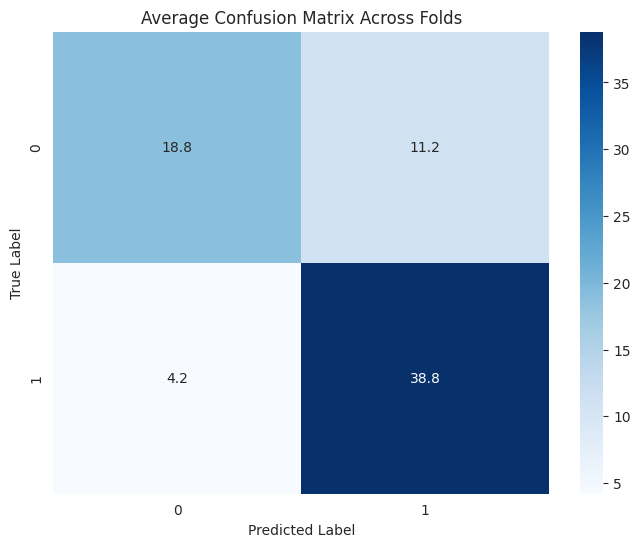

In [61]:
# Number of folds for Stratified K-fold
n_splits = 5

# Weights of the classes
class_weight = {0: 1, 1: 1.5}

# Threshold for the classification as sick
threshold = 0.48

# Custom function to run the model
optimize.CV_NN_stats(X, y, n_splits, class_weight, threshold, 'CNN')

warnings.filterwarnings('ignore')

From these reuslts we can notice that, even if the CNN was trained on tabular data, it obtained good results and performed better than LDA and Random Forest. This is probably due to the fact that the CNN is able to capture more complex patterns in the data, probably correlations between features that are not linear or hierarchical structures in the data. However, the CNN is not able to outperform the Logistic Regression and the SVM, which are still the best models.

## Neural Network

The structure of the neural network is the following:
- 4 Dense layers with 128 neurons
- 4 Dense layers with 64 neurons
- 1 Output layer with 1 neuron

It is very similar to the CNN, but it does not have the convolutional layers. All the other parameters are the same as before.

3/3 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.70      0.78        33
         1.0       0.79      0.93      0.85        40

    accuracy                           0.82        73
   macro avg       0.84      0.81      0.82        73
weighted avg       0.83      0.82      0.82        73



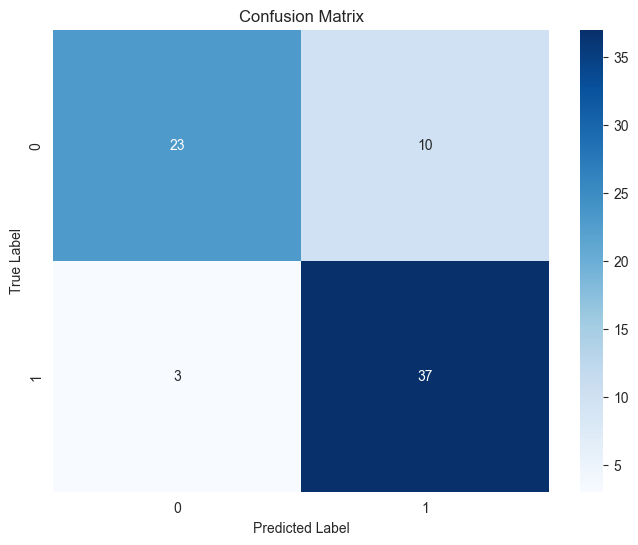

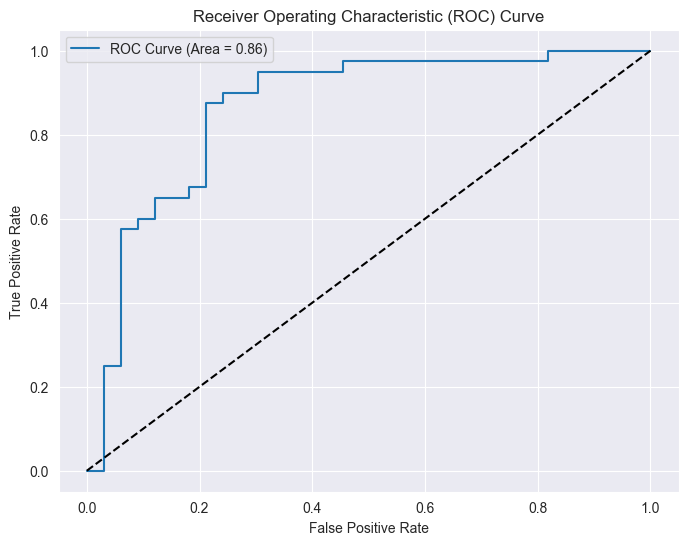

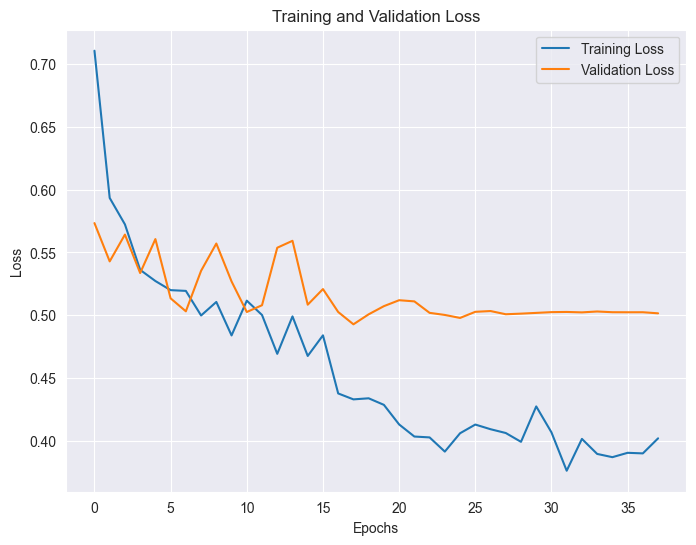

3/3 [==============================] - 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82        33
         1.0       0.87      0.82      0.85        40

    accuracy                           0.84        73
   macro avg       0.83      0.84      0.83        73
weighted avg       0.84      0.84      0.84        73



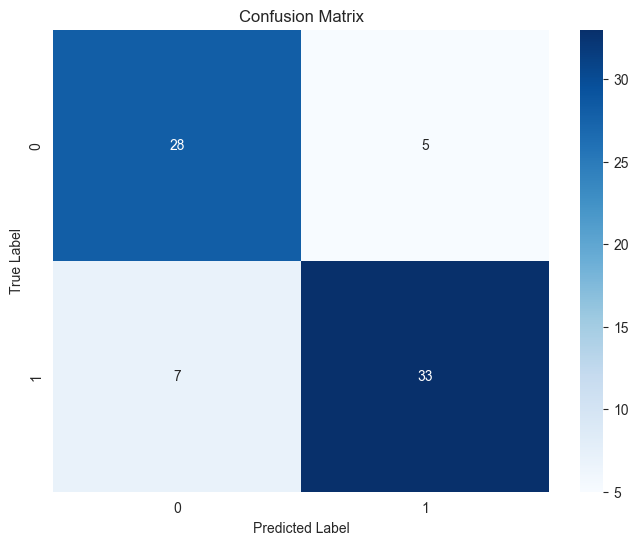

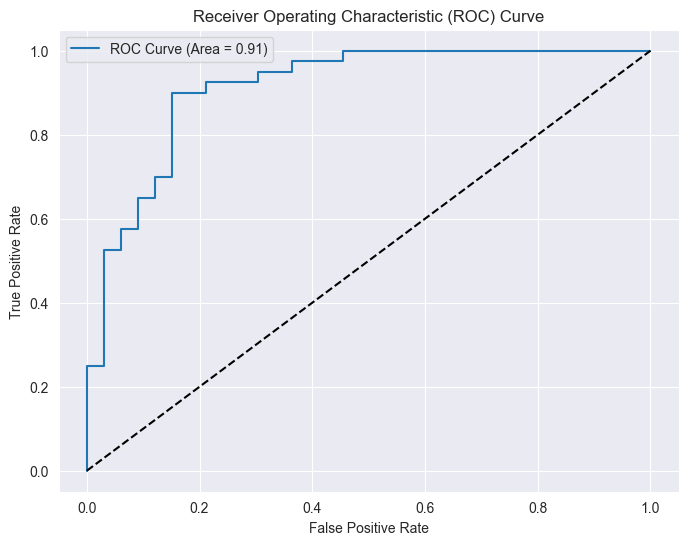

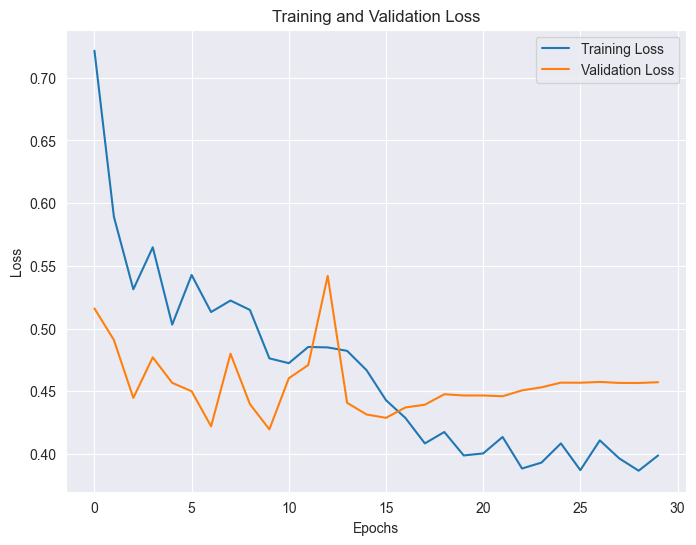

3/3 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.74      0.79        31
         1.0       0.83      0.90      0.86        42

    accuracy                           0.84        73
   macro avg       0.84      0.82      0.83        73
weighted avg       0.84      0.84      0.83        73



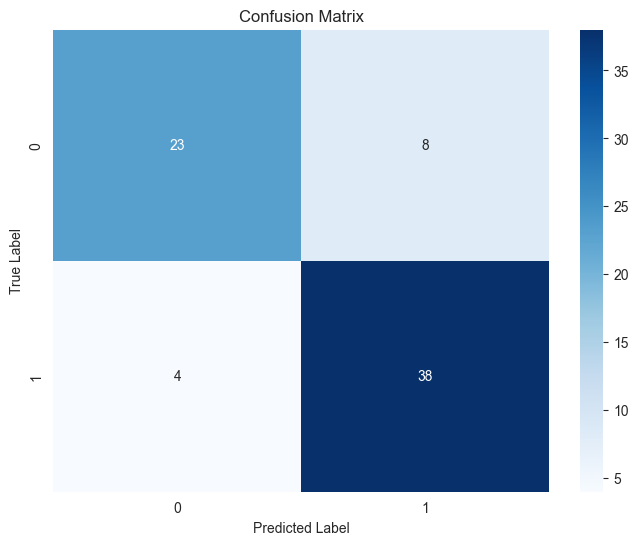

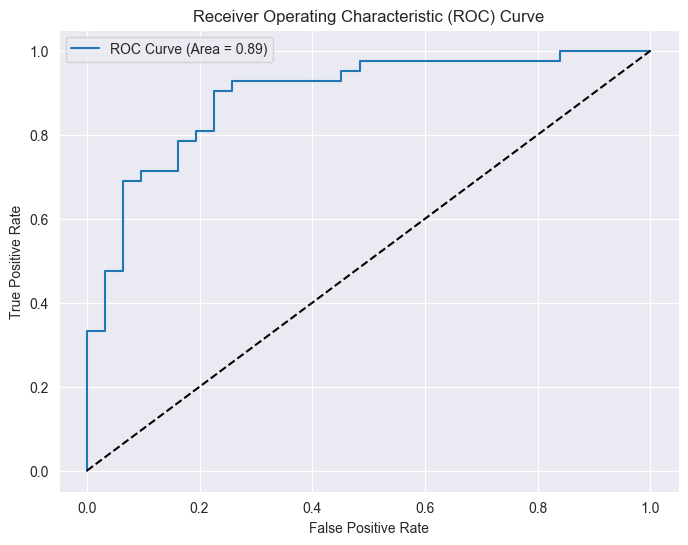

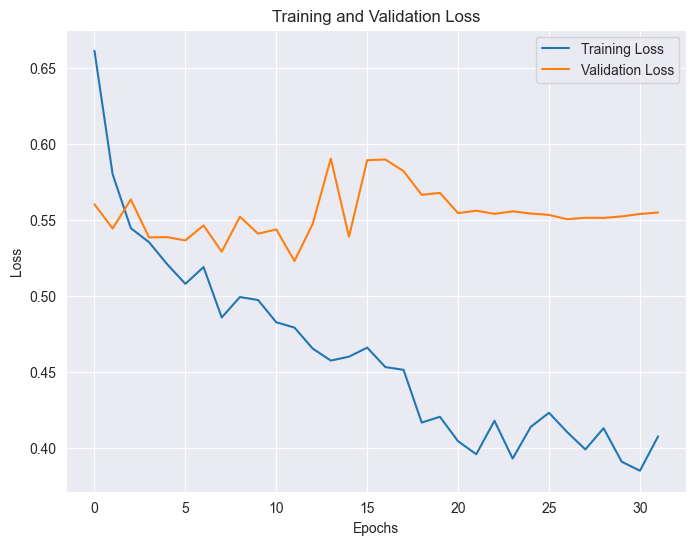

3/3 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77        30
         1.0       0.85      0.81      0.83        43

    accuracy                           0.81        73
   macro avg       0.80      0.81      0.80        73
weighted avg       0.81      0.81      0.81        73



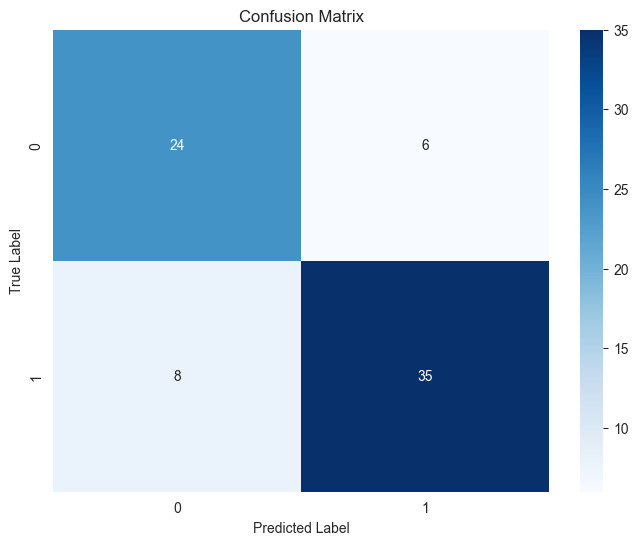

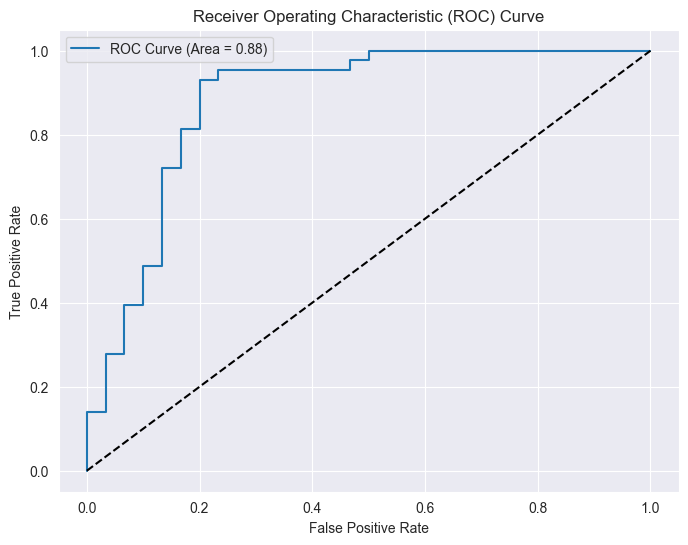

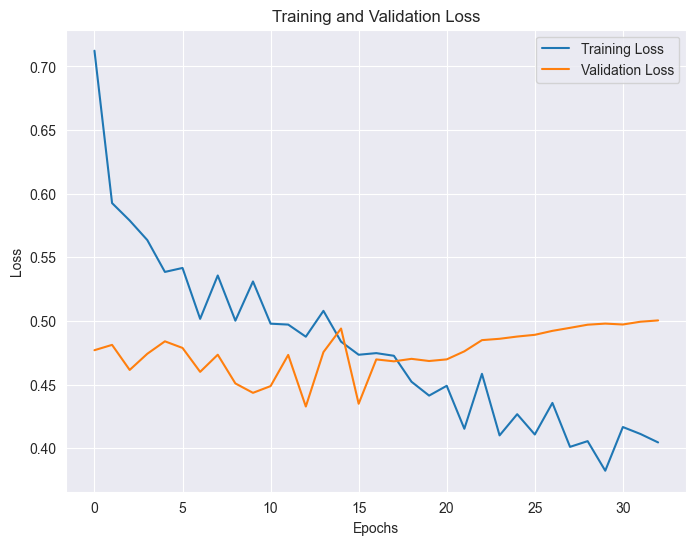

3/3 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76        32
         1.0       0.82      0.78      0.80        41

    accuracy                           0.78        73
   macro avg       0.78      0.78      0.78        73
weighted avg       0.78      0.78      0.78        73



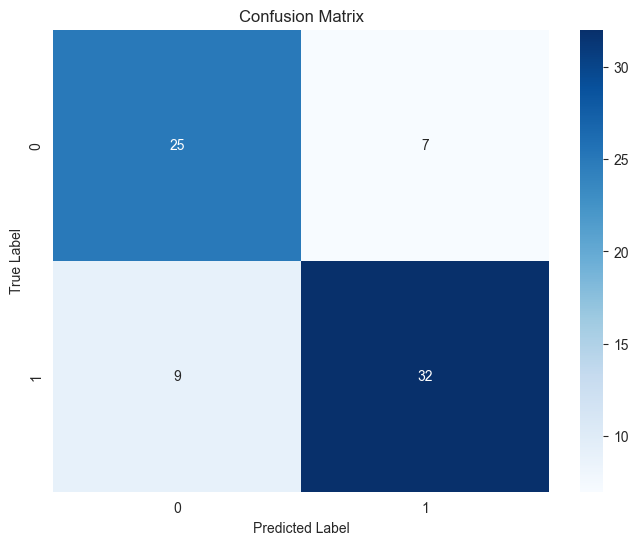

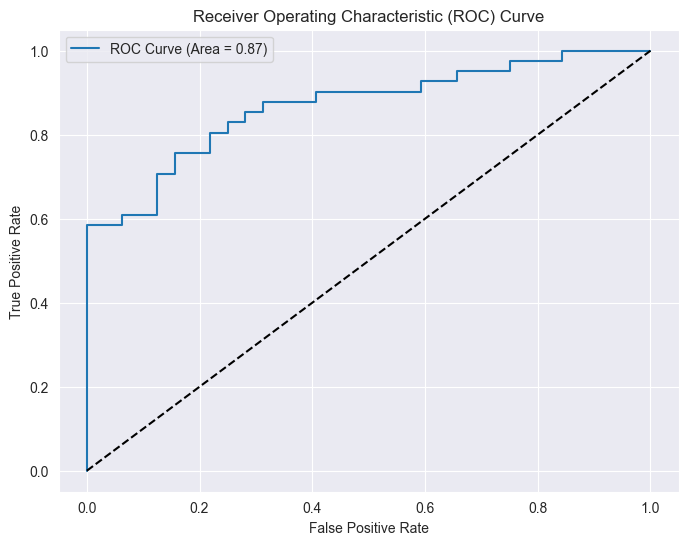

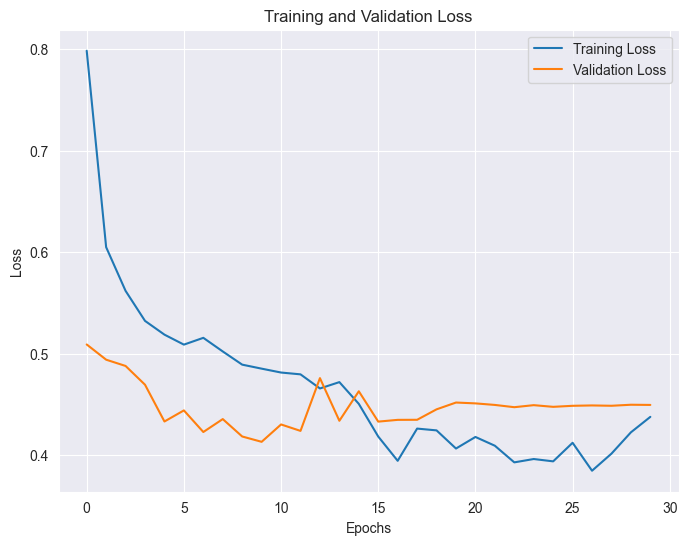

------------------------------------------------------------------------------------------------ 
 ------------------------------------------------------------------------------------------------ 
 ------------------------------------------------------------------------------------------------ 
 ------------------------------------------------------------------------------------------------ 

Mean AUC: 0.88 (+/- 0.02)
Mean F1 Score: 0.82 (+/- 0.02)
Mean FN Rate: 0.08 (+/- 0.03)
Mean Accuracy: 0.81 (+/- 0.02)


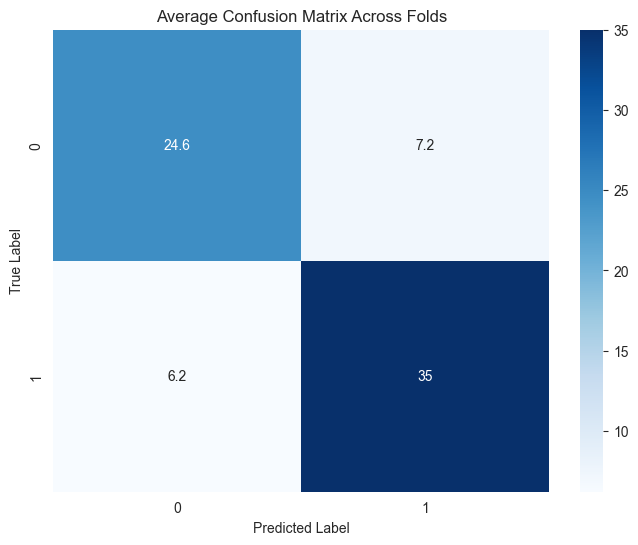

In [ ]:
# Number of folds for Stratified K-fold
n_splits = 5

# Weights of the classes
class_weight = {0: 1, 1: 1.5}

# Threshold for the classification as sick
threshold = 0.48

optimize.CV_NN_stats(X, y, n_splits, class_weight, threshold, 'NN')

warnings.filterwarnings('ignore')

The results of the Neural Network are good, but not significantly better than those obtained with the other models, thus simpler and more interpretable models are preferable.

# Conclusions and Future work

The following are the results of the models that we have trained:

| Model                        | Logistic Regression (balanced) |  Logistic regression (weighted)          | Linear Discriminant Analysis | Random Forest | SVM   | CNN  | NN   |
|------------------------------|---------------------            |-----------------------  |------------------------------|---------------|-------|------|------|
| F1                           | 0.81442                         |  0.77995| 0.80921                         | 0.80939          | 0.77221  |  0.78  |  0.82    |
| AUC-ROC                      | 0.88011                         | 0.89789 | 0.88335                         | 0.88678          | 0.87637  |  0.88  |   0.88   |
| Accuracy                     | 0.81522                         | 0.78804 | 0.80978                         | 0.80978          | 0.78261  |  0.79     |  0.81    |
| Precision                    | 0.81538                         | 0.81015 | 0.81016                         | 0.80943          | 0.81016  |    0.78  |  0.83    |
| FN rate | 7 % |   3% |    8 % | 8% | 2 % | 6 % | 8 %

For our problem the most important metrics are the FN rate, the AUC-ROC and the precision. As we already stated, low FN are vital since not detecting a hearth disease can lead to death. We also considered the AUC-ROC, which is a good indicator of the model's ability to distinguish between classes and the precision, which is the ratio of correctly predicted positive observations to the total predicted positive observations since false positives, even though they have way lighter consequences compared to FN, can still lead to unnecessary stress, costs, and medical procedures for patients.

As we can see from the table above, Logistic Regression, Linear Discriminant Analysis and Random Forest have the better overall metrics. Instead, CNN and NN do not perform much betther than those simpler models. Moreover, we have that the Support Vector Machines achieve the minimum rate of false negatives.

In the end, we cannot choose a better overall model, but we have to consider a trade-off among all metrics. We can conclude that the best models for us are:
- Weighted Logistic Regression with low false negatives or balanced Logistic Regression, with good overall metrics and contained false negatives
- Support Vector Machines, for the lower rate of false negatives, i.e. 2 %

For upcoming analyses, it could be worthwhile to investigate some aspects related to both the choice of the dataset and the tuning of neural network parameters. In particular, for datasets, it might be interesting to consider more extensive data to validate the robustness of the model.
The future work of the project definitely involves improving the metrics by reducing both false negatives and false positives, achieving optimal metrics in predicting heart-related diseases.
As for the parameters, one could contemplate adding more layers and considering more complex neural network  to achieve optimal results. Furthermore, it could be worth it to investigate the behavior of the CNN and why it was able to outperform the vanilla NN, even if we dealt with tabular data.

# References

1. [*Deep Convolutional Neural Network for the Early Detection of Heart Disease*](https://www.mdpi.com/2227-9059/10/11/2796) 
2. [*Comparison of Machine Learning Algorithms for the Prediction of Heart Disease*](https://www.ijraset.com/fileserve.php?FID=32591)
3. [UCI Heart Disease dataset](https://archive.ics.uci.edu/dataset/45/heart+disease)
